# Training a model using Synthetic Data

In [1]:
from __future__ import absolute_import
from __future__ import print_function
from __future__ import division

import tensorflow as tf
import numpy as np
import os
import time
from datetime import datetime
from six.moves import cPickle as pickle

Loading Synthethic data

In [2]:
file_name = 'Synthetic_data/SyntheticData32.pickle'
with open(file_name, 'rb') as f:
    save = pickle.load(f)
    train_dataset = save['train_dataset']
    train_labels = save['train_labels']
    valid_dataset = save['valid_dataset']
    valid_labels = save['valid_labels']
    test_dataset = save['test_dataset']
    test_labels = save['test_labels']
    del save

valid_dataset = valid_dataset[:3000]
valid_labels = valid_labels[:3000]
test_dataset = test_dataset[:10000]
test_labels = test_labels[:10000]
print(train_dataset.shape, train_labels.shape)
print(test_dataset.shape, test_labels.shape)
print(valid_dataset.shape, valid_labels.shape)

(160000, 32, 32, 1) (160000, 5)
(10000, 32, 32, 1) (10000, 5)
(3000, 32, 32, 1) (3000, 5)


In [3]:
def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 2).T == labels) / predictions.shape[1] / predictions.shape[0])

In [10]:
image_size = 32
num_labels = 11  # 0-9, + blank 
num_channels = 1 # grayscale
num_digits = 4

batch_size = 64
patch_size = 5
depth1 = 16
depth2 = 32
depth3 = 64
num_hidden1 = 64
num_hidden2 = 64

graph = tf.Graph()
with graph.as_default():
    # Input data.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size, image_size, num_channels))
    tf_train_labels = tf.placeholder(tf.int32, shape=(batch_size, num_digits+1))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    
    # Variables.
    layer1_weights = tf.get_variable("W1", shape=[patch_size, patch_size, num_channels, depth1],\
                                    initializer=tf.contrib.layers.xavier_initializer_conv2d())
    layer1_biases = tf.Variable(tf.constant(1.0, shape=[depth1]), name='B1')
    layer2_weights = tf.get_variable("W2", shape=[patch_size, patch_size, depth1, depth2],\
                                    initializer=tf.contrib.layers.xavier_initializer_conv2d())
    layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth2]), name='B2')
    layer3_weights = tf.get_variable("W3", shape=[patch_size, patch_size, depth2, num_hidden1],\
                                    initializer=tf.contrib.layers.xavier_initializer_conv2d())
    layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden1]), name='B3')

    # Sequence length
    ss_w = tf.get_variable("WSS", shape=[num_hidden2, num_digits + 1],\
                           initializer=tf.contrib.layers.xavier_initializer())
    ss_b = tf.Variable(tf.constant(1.0, shape=[num_digits+1]), name='BSS')
    
    # Digits
    s1_w = tf.get_variable("WS1", shape=[num_hidden2, num_labels],\
                           initializer=tf.contrib.layers.xavier_initializer())
    s1_b = tf.Variable(tf.constant(1.0, shape=[num_labels]), name='BS1')
    s2_w = tf.get_variable("WS2", shape=[num_hidden2, num_labels],\
                           initializer=tf.contrib.layers.xavier_initializer())
    s2_b = tf.Variable(tf.constant(1.0, shape=[num_labels]), name='BS2')
    s3_w = tf.get_variable("WS3", shape=[num_hidden2, num_labels],\
                           initializer=tf.contrib.layers.xavier_initializer())
    s3_b = tf.Variable(tf.constant(1.0, shape=[num_labels]), name='BS3')   
    s4_w = tf.get_variable("WS4", shape=[num_hidden2, num_labels],\
                           initializer=tf.contrib.layers.xavier_initializer())
    s4_b = tf.Variable(tf.constant(1.0, shape=[num_labels]), name='BS4') 
    
    # Model.
    def model(data, keep_prob):
        conv = tf.nn.conv2d(data, layer1_weights, [1,1,1,1], 'VALID', name='C1')
        hidden = tf.nn.relu(conv + layer1_biases)
        lrn = tf.nn.local_response_normalization(hidden)
        sub = tf.nn.max_pool(lrn, [1,2,2,1], [1,2,2,1], 'SAME', name='S2')
        
        conv = tf.nn.conv2d(sub, layer2_weights, [1,1,1,1], padding='VALID', name='C3')
        hidden = tf.nn.relu(conv + layer2_biases)
        lrn = tf.nn.local_response_normalization(hidden)
        sub = tf.nn.max_pool(lrn, [1,2,2,1], [1,2,2,1], 'SAME', name='S4')
        
        conv = tf.nn.conv2d(sub, layer3_weights, [1,1,1,1], padding='VALID', name='C5')
        hidden = tf.nn.relu(conv + layer3_biases)
        hidden = tf.nn.dropout(hidden, keep_prob)
        shape = hidden.get_shape().as_list()
        reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])

        logits0 = tf.matmul(reshape, ss_w) + ss_b
        # This concat only allow us to have a one hot vector like the others (to pack the results in the following lines)
        logits0 = tf.concat(1, [logits0, tf.zeros([shape[0],6])])
        logits1 = tf.matmul(reshape, s1_w) + s1_b
        logits2 = tf.matmul(reshape, s2_w) + s2_b
        logits3 = tf.matmul(reshape, s3_w) + s3_b
        logits4 = tf.matmul(reshape, s4_w) + s4_b
        return [logits0, logits1, logits2, logits3, logits4]
    
    # Training computation.
    [logits0, logits1, logits2, logits3, logits4] = model(tf_train_dataset, 0.975)
    loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits0, tf_train_labels[:,0])) +\
        tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits1, tf_train_labels[:,1])) +\
        tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits2, tf_train_labels[:,2])) +\
        tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits3, tf_train_labels[:,3])) +\
        tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits4, tf_train_labels[:,4]))
        
    # Optimizer.
    global_step = tf.Variable(0)
    learning_rate = tf.train.exponential_decay(0.05, global_step, 10000, 0.95)
    optimizer = tf.train.AdagradOptimizer(learning_rate).minimize(loss, global_step=global_step)
    
    
    # Predictions for the training, validation, and test data.
    train_prediction = tf.pack([tf.nn.softmax(model(tf_train_dataset, 1.0)[0]),\
                                tf.nn.softmax(model(tf_train_dataset, 1.0)[1]),\
                                tf.nn.softmax(model(tf_train_dataset, 1.0)[2]),\
                                tf.nn.softmax(model(tf_train_dataset, 1.0)[3]),\
                                tf.nn.softmax(model(tf_train_dataset, 1.0)[4])])
    valid_prediction = tf.pack([tf.nn.softmax(model(tf_valid_dataset, 1.0)[0]),\
                                tf.nn.softmax(model(tf_valid_dataset, 1.0)[1]),\
                                tf.nn.softmax(model(tf_valid_dataset, 1.0)[2]),\
                                tf.nn.softmax(model(tf_valid_dataset, 1.0)[3]),\
                                tf.nn.softmax(model(tf_valid_dataset, 1.0)[4])])
    test_prediction = tf.pack([tf.nn.softmax(model(tf_test_dataset, 1.0)[0]),\
                                tf.nn.softmax(model(tf_test_dataset, 1.0)[1]),\
                                tf.nn.softmax(model(tf_test_dataset, 1.0)[2]),\
                                tf.nn.softmax(model(tf_test_dataset, 1.0)[3]),\
                                tf.nn.softmax(model(tf_test_dataset, 1.0)[4])])
    
    saver = tf.train.Saver()

In [11]:
filename = "Models/Synthetic_Model.ckpt"
num_steps = 15000

with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()  
    
    if os.path.exists(filename):
        reader = tf.train.NewCheckpointReader(filename)
        reader.get_variable_to_shape_map()
        saver.restore(session, filename)
        print('Model restored.')
    print('Initialized')
  
    for step in range(num_steps):
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
        batch_labels = train_labels[offset:(offset + batch_size),:]
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
        
        if (step % 500 == 0): 
            print('Minibatch loss at step %d: %f' % (step, l))
            print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels[:,0:]))
            print('Validation accuracy: %.1f%%' % accuracy(valid_prediction.eval(), valid_labels[:,0:]))
            
    print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels[:,0:]))
    save_path = saver.save(session, filename)
    print("Model saved in file: %s" % save_path)    

Initialized
Minibatch loss at step 0: 13.656919
Minibatch accuracy: 9.4%
Validation accuracy: 28.3%
Minibatch loss at step 500: 4.450424
Minibatch accuracy: 69.1%
Validation accuracy: 69.2%
Minibatch loss at step 1000: 3.041061
Minibatch accuracy: 79.7%
Validation accuracy: 77.9%
Minibatch loss at step 1500: 2.184394
Minibatch accuracy: 85.9%
Validation accuracy: 83.6%
Minibatch loss at step 2000: 2.114888
Minibatch accuracy: 87.5%
Validation accuracy: 85.2%
Minibatch loss at step 2500: 1.843859
Minibatch accuracy: 89.1%
Validation accuracy: 87.5%
Minibatch loss at step 3000: 1.476864
Minibatch accuracy: 91.6%
Validation accuracy: 88.5%
Minibatch loss at step 3500: 1.116499
Minibatch accuracy: 93.1%
Validation accuracy: 89.4%
Minibatch loss at step 4000: 2.062691
Minibatch accuracy: 86.6%
Validation accuracy: 89.9%
Minibatch loss at step 4500: 1.272256
Minibatch accuracy: 93.1%
Validation accuracy: 90.7%
Minibatch loss at step 5000: 1.102963
Minibatch accuracy: 93.1%
Validation accurac

## Performance on Testing set

Selecting 10 random images

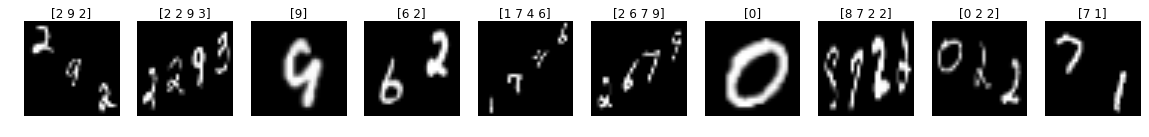

In [12]:
from PIL import Image
import os
import sys
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = (20.0, 20.0)
f, ax = plt.subplots(nrows=1, ncols=10)

im_samples = []
    
for i,j in enumerate(np.sort(np.random.randint(0, test_labels.shape[0], size = 10))):
    im_samples.extend([j])
    ax[i].axis('off')
    label = test_labels[j,1:1+test_labels[j,0]]
    ax[i].set_title(label, loc='center')
    ax[i].imshow(test_dataset[j,:,:,0],cmap="gray")
